### Plot zonal velocity at 4 transects along the Antarctic margin

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
from scipy.io import loadmat
import mat73
from xgcm import Grid

import warnings
warnings.simplefilter("ignore")

from dask.distributed import Client
from dask.distributed import LocalCluster 

cluster = LocalCluster()
client = Client(cluster) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35005,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.94 GiB
Comm: tcp://127.0.0.1:46238,Total threads: 2
Dashboard: http://127.0.0.1:41650/status,Memory: 7.73 GiB
Nanny: tcp://127.0.0.1:44786,


### Load time-averaged SOSE 1/12th output - this has been cropped to just values south of 60S

In [17]:
# Read .mat files as python dictionaries
dict_uvel_sose = mat73.loadmat('/archive/Rebecca.Beadling/SOSE_to_transfer_new/UvelForEllyn.mat')
dict_grid_sose = mat73.loadmat('/archive/Rebecca.Beadling/SOSE_to_transfer_new/grid.mat')

sose_u = xr.DataArray(dict_uvel_sose["U"],dims={"xg":dict_uvel_sose["xg"], "yc":dict_uvel_sose["yc"], "z":dict_uvel_sose["z"]})
sose_u = sose_u.assign_coords({"xg":dict_uvel_sose["xg"], "yc":dict_uvel_sose["yc"], "z":dict_uvel_sose["z"]})
sose_u = sose_u.transpose("z","yc","xg").chunk({'z':10})

# Slice static fields to 643 points since the u and v output has been cropped
sose_depth = xr.DataArray(dict_grid_sose["Depth"],dims={"xg":sose_u["xg"], "yc":sose_u["yc"]})
sose_DRF = xr.DataArray(dict_grid_sose["DRF"],dims={"z":dict_uvel_sose["z"]})
sose_hFaCW = xr.DataArray(dict_grid_sose["hFacW"],dims=({"xg":sose_u["xg"], "yc":sose_u["yc"],"z":sose_u["z"]}))
sose_DYG = xr.DataArray(dict_grid_sose["DYG"],dims=({"xg":sose_u["xg"], "yc":sose_u["yc"]}))

sose_depth = sose_depth.transpose("yc","xg").isel(yc=slice(0,643))
sose_hFacW = sose_hFaCW.transpose("z","yc","xg").isel(yc=slice(0,643))
sose_DYG = sose_DYG.transpose("yc","xg").isel(yc=slice(0,643))

sose_depth = sose_depth.assign_coords({"xg":sose_u["xg"],"yc":sose_u["yc"]})
sose_hFacW = sose_hFacW.assign_coords({"xg":sose_u["xg"],"yc":sose_u["yc"],"z":sose_u["z"]})
sose_DRF = sose_DRF.assign_coords({"z":dict_uvel_sose["z"]}).chunk({'z':10})
sose_DYG = sose_DYG.assign_coords({"xg":sose_u["xg"],"yc":sose_u["yc"]})

## Put into single Dataset
sose_velocity = xr.Dataset({'sose_u':sose_u, 
                            'sose_depth':sose_depth,
                            'sose_hFacW':sose_hFacW,
                            'sose_DRF':sose_DRF,
                            'sose_DYG':sose_DYG},
                           coords={'xg':sose_u['xg'],
                                   'yc':sose_u['yc'],
                                   'z':sose_u['z']
                                  })

### Define Antarctic Slope Current Transects

In [10]:
## 20E
asc_20e = sose_velocity.sose_u.sel(yc=slice(-70.5,-68)).sel(xg=20,method='nearest')
## 150E
asc_150e = sose_velocity.sose_u.sel(yc=slice(-69,-65.2)).sel(xg=150,method='nearest')
## 130W
asc_130w = sose_velocity.sose_u.sel(yc=slice(-75,-72)).sel(xg=230,method='nearest')
## 80W
asc_80w = sose_velocity.sose_u.sel(yc=slice(-74,-68)).sel(xg=280,method='nearest')

In [4]:
import sectionate
asc_20e_lat_1 = -70.5
asc_20e_lat_2 = -68.0
asc_20e_lon_1 = 20.0
asc_20e_lon_2 = 20.0

asc_150e_lat_1 = -69
asc_150e_lat_2 = -65.2
asc_150e_lon_1 = 150
asc_150e_lon_2 = 150

asc_130w_lat_1 = -75
asc_130w_lat_2 = -72
asc_130w_lon_1 = 230
asc_130w_lon_2 = 230

asc_80w_lat_1 = -74
asc_80w_lat_2 = -68
asc_80w_lon_1 = 280
asc_80w_lon_2 = 280

lat, lon = xr.broadcast(sose_velocity.yc,sose_velocity.xg)
i20e, j20e, x20e, y20e = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_20e_lon_1,
                                                   asc_20e_lat_1,
                                                   asc_20e_lon_2,
                                                   asc_20e_lat_2)
i150e, j150e, x150e, y150e = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_150e_lon_1,
                                                   asc_150e_lat_1,
                                                   asc_150e_lon_2,
                                                   asc_150e_lat_2)
i130w, j130w, x130w, y130w = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_130w_lon_1,
                                                   asc_130w_lat_1,
                                                   asc_130w_lon_2,
                                                   asc_130w_lat_2)
i80w, j80w, x80w, y80w = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_80w_lon_1,
                                                   asc_80w_lat_1,
                                                   asc_80w_lon_2,
                                                   asc_80w_lat_2)

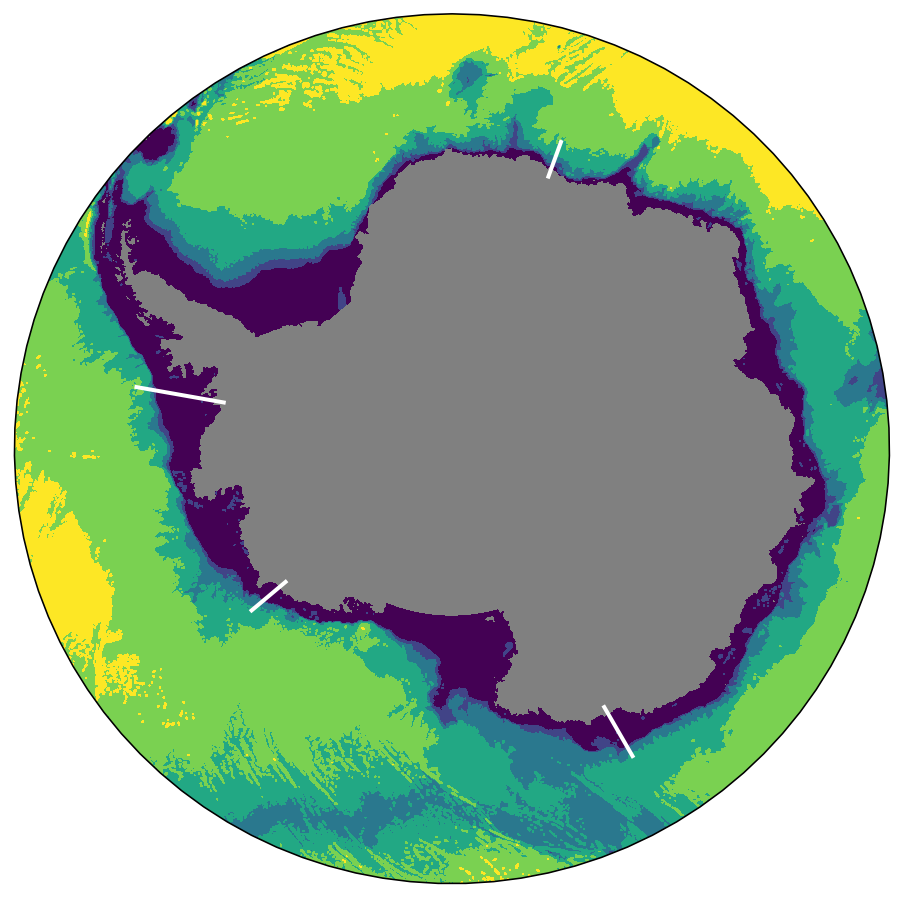

In [77]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo(central_longitude = 0)
ax = plt.axes(projection=projection,facecolor='grey')
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = sose_velocity.sose_depth.where(sose_velocity.sose_depth>0).plot.contourf(x='xg', y='yc',
                        transform=ccrs.PlateCarree(),cmap='viridis',add_colorbar=False)

plt.plot(x20e,y20e,'-',color='white',linewidth=2,transform=ccrs.PlateCarree())
plt.plot(x150e,y150e,'-',color='white',linewidth=2,transform=ccrs.PlateCarree())
plt.plot(x130w,y130w,'-',color='white',linewidth=2,transform=ccrs.PlateCarree())
plt.plot(x80w,y80w,'-',color='white',linewidth=2,transform=ccrs.PlateCarree())

### Functions to plot models true bathymetry accounting for partial cells¶

In [5]:
## Cannot have NaNs to use as coordinate in pcolormesh:
def forward_fill(arr):
    """ Forward fill a 2-D array along the column dimension"""
    # make a copy of the input array
    out = arr * 1.0
    # loop over column index
    for col_idx in range(0,arr.shape[1]):
        # get the column to work on
        _row = arr[:,col_idx]
        # get index numbers of nan values
        _nan_vals = np.argwhere(np.isnan(_row))
        # find the last "good" value
        _depth = 0. if _nan_vals[0] == 0 else _row[_nan_vals[0]-1]
        # set nan values to the last good value
        _row = np.where(np.isnan(_row),_depth,_row)
        # re-assign the filled column
        out[:,col_idx] = _row
    return out

def depth_to_center_partial(arr):
    kmax = arr.shape[0]
    zl  = 0.0 * arr[:]                              
    zl[0] = 0.5 * arr[0] 
    
    k = 1
    while k < kmax:
        zl[k] = zl[k-1] + 0.5 * (arr[k]+arr[k-1])
        k=k+1
    
    zl_nm = np.array(zl)
    
    #zl = forward_fill(zl_nm)
    
    return zl_nm

In [6]:
### Compute grid cell thickness
sose_thk = sose_velocity.sose_DRF * sose_velocity.sose_hFacW
sose_thk = sose_thk.where(sose_thk != 0) 
## 20e
thk_20e_sose = sose_thk.sel(xg=20,method='nearest').sel(yc=slice(-70.5,-68)).load()
lat_20e_sose = sose_thk.yc.sel(yc=slice(-70.5,-68))

thk_150e_sose = sose_thk.sel(xg=150,method='nearest').sel(yc=slice(-69,-65.2)).load()
lat_150e_sose = sose_thk.yc.sel(yc=slice(-69,-65.2))

thk_130w_sose = sose_thk.sel(xg=230,method='nearest').sel(yc=slice(-75,-72)).load()
lat_130w_sose = sose_thk.yc.sel(yc=slice(-75,-72))

thk_80w_sose = sose_thk.sel(xg=280,method='nearest').sel(yc=slice(-74,-68)).load()
lat_80w_sose = sose_thk.yc.sel(yc=slice(-74,-68))

zl_20e_sose = depth_to_center_partial(thk_20e_sose)
zl_150e_sose = depth_to_center_partial(thk_150e_sose)
zl_130w_sose = depth_to_center_partial(thk_130w_sose)
zl_80w_sose = depth_to_center_partial(thk_80w_sose)

lat_20e_sose = np.broadcast_to(lat_20e_sose,zl_20e_sose.shape)
lat_150e_sose = np.broadcast_to(lat_150e_sose,zl_150e_sose.shape)
lat_130w_sose = np.broadcast_to(lat_130w_sose,zl_130w_sose.shape)
lat_80w_sose = np.broadcast_to(lat_80w_sose,zl_80w_sose.shape)

### Compute volume transport along sections: Utrans  = uvel x DYG x DRF x hFacW

In [30]:
##  20e:
sose_hFacW_20e = sose_velocity.sose_hFacW.sel(yc=slice(-70.5,-68)).sel(xg=20,method='nearest')
sose_DYG_20e = sose_velocity.sose_DYG.sel(yc=slice(-70.5,-68)).sel(xg=20,method='nearest')
U_20e = sose_hFacW_20e*sose_DYG_20e*sose_velocity.sose_DRF*asc_20e
U_20e_total = U_20e.sum(dim=['yc','z'])*(1/10**6)

## 150e
sose_hFacW_150e = sose_velocity.sose_hFacW.sel(yc=slice(-69,-65.2)).sel(xg=150,method='nearest')
sose_DYG_150e = sose_velocity.sose_DYG.sel(yc=slice(-69,-65.2)).sel(xg=150,method='nearest')
U_150e = sose_hFacW_150e*sose_DYG_150e*sose_velocity.sose_DRF*asc_150e
U_150e_total = U_150e.sum(dim=['yc','z'])*(1/10**6)

## 130w
sose_hFacW_130w = sose_velocity.sose_hFacW.sel(yc=slice(-75,-72)).sel(xg=230,method='nearest')
sose_DYG_130w = sose_velocity.sose_DYG.sel(yc=slice(-75,-72)).sel(xg=230,method='nearest')
U_130w = sose_hFacW_130w*sose_DYG_130w*sose_velocity.sose_DRF*asc_130w
U_130w_total = U_130w.sum(dim=['yc','z'])*(1/10**6)

## 80w
sose_hFacW_80w = sose_velocity.sose_hFacW.sel(yc=slice(-74,-68)).sel(xg=280,method='nearest')
sose_DYG_80w = sose_velocity.sose_DYG.sel(yc=slice(-74,-68)).sel(xg=280,method='nearest')
U_80w = sose_hFacW_80w*sose_DYG_80w*sose_velocity.sose_DRF*asc_80w
U_80w_total = U_80w.sum(dim=['yc','z'])*(1/10**6)

In [32]:
U_20e_total.values,\
U_150e_total.values,\
U_130w_total.values,\
U_80w_total.values,

(array(-18.378714, dtype=float32),
 array(-13.901259, dtype=float32),
 array(-2.874114, dtype=float32),
 array(-8.206103, dtype=float32))

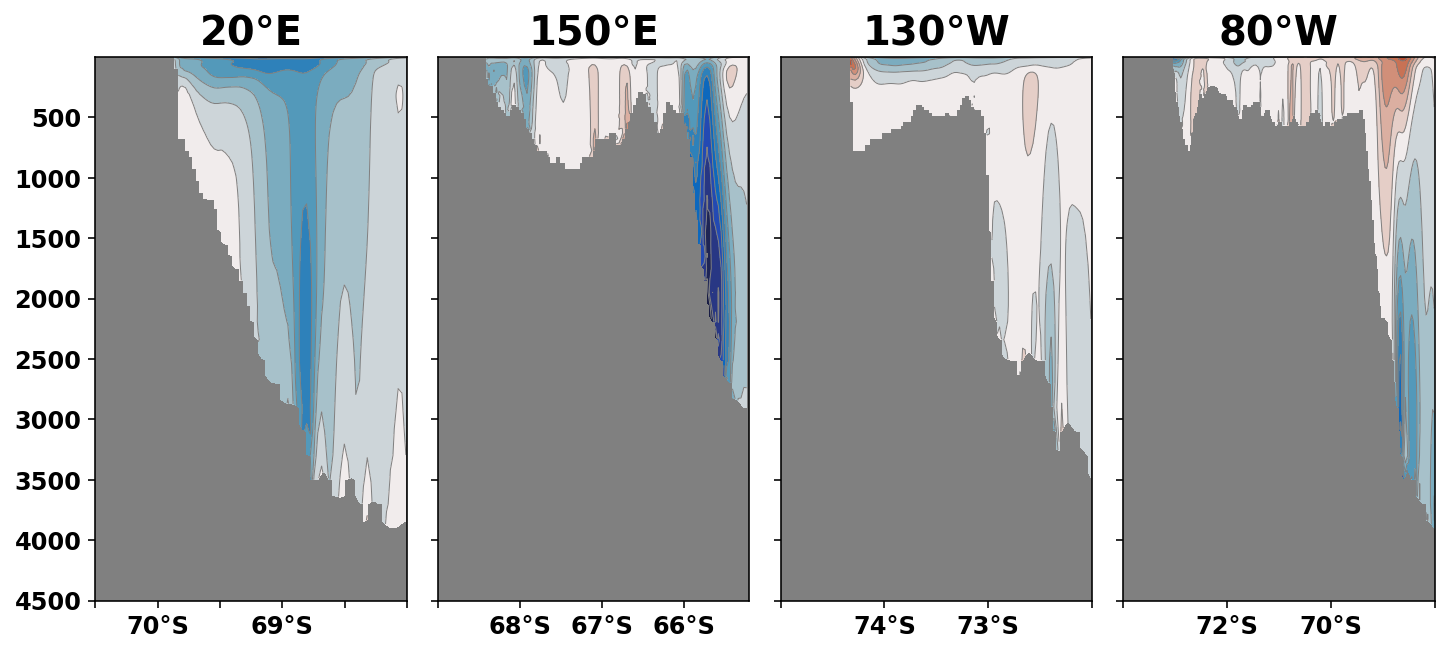

In [33]:
from matplotlib import gridspec

fig, ax = plt.subplots(1,4,figsize=(12,5))
gs = gridspec.GridSpec(1,4,wspace=0.1)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0],facecolor='grey'),\
                     plt.subplot(gs[0,1],facecolor='grey'),\
                     plt.subplot(gs[0,2],facecolor='grey'),\
                     plt.subplot(gs[0,3],facecolor='grey')

custom_ylim = (-4500,-1)
plt.setp(ax1, ylim=custom_ylim, xlim=(-70.5,-68))
plt.setp(ax2, ylim=custom_ylim, xlim=(-69,-65.2))
plt.setp(ax3, ylim=custom_ylim, xlim=(-75,-72))
plt.setp(ax4, ylim=custom_ylim, xlim=(-74,-68))

levels_vel = np.linspace(-0.16,0.16,20)

ax1.contourf(lat_20e_sose,-zl_20e_sose,asc_20e.where(asc_20e != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax1.contour(lat_20e_sose,-zl_20e_sose,asc_20e.where(asc_20e != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax2.contourf(lat_150e_sose,-zl_150e_sose,asc_150e.where(asc_150e != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax2.contour(lat_150e_sose,-zl_150e_sose,asc_150e.where(asc_150e != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax3.contourf(lat_130w_sose,-zl_130w_sose,asc_130w.where(asc_130w != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax3.contour(lat_130w_sose,-zl_130w_sose,asc_130w.where(asc_130w != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax4.contourf(lat_80w_sose,-zl_80w_sose,asc_80w.where(asc_80w != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax4.contour(lat_80w_sose,-zl_80w_sose,asc_80w.where(asc_80w != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax1.yaxis.set_ticklabels([4500,4000,3500,3000,2500,2000,1500,1000,500],weight='bold',fontsize=12)
ax2.yaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])

ax1.xaxis.set_ticklabels(['','70\N{degree sign}S','','69\N{degree sign}S'],weight='bold',fontsize=12)
ax2.xaxis.set_ticklabels(['','68\N{degree sign}S','67\N{degree sign}S','66\N{degree sign}S'],weight='bold',fontsize=12)
ax3.xaxis.set_ticklabels(['','74\N{degree sign}S','73\N{degree sign}S'],weight='bold',fontsize=12)
ax4.xaxis.set_ticklabels(['','72\N{degree sign}S','70\N{degree sign}S'],weight='bold',fontsize=12)

ax1.set_title('20\N{degree sign}E',weight='bold',fontsize=20)
ax2.set_title('150\N{degree sign}E',weight='bold',fontsize=20)
ax3.set_title('130\N{degree sign}W',weight='bold',fontsize=20)
ax4.set_title('80\N{degree sign}W',weight='bold',fontsize=20)

plt.savefig('SOSE_velocity_cross_sections.pdf')